### Data Exploration for ScienceSage

- [Load Processed Data](#load-processed-data)
- [Duplicate Chunks](#duplicate-chunks)
- [Number of Articles and Chunks](#number-of-articles-and-chunks)
- [Category Distribution](#category-distribution)
- [Chunks per Article](#chunks-per-article)
- [Chunks per Source](#chunks-per-source)
- [Chunk Position Analysis](#chunk-position-analysis)
- [Image Coverage](#image-coverage)
- [Summary Length](#summary-length)
- [Word Count Analysis](#word-count-analysis)
- [Topic/Keyword Distribution (Word Cloud)](#topickeyword-distribution-word-cloud)
- [Name Entity Frequency](#name-entity-frequency)
- [Correlation Analysis between Numeric Features](#correlation-analysis-between-numeric-features)
- [Observations](#observations)

In [1]:
import os
import json
import pandas as pd
import numpy as np
import ast
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import spacy
import nltk

nltk.download("punkt", download_dir="/tmp")
nltk.download("stopwords", download_dir="/tmp")
nltk.data.path.append("/tmp")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /tmp...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /tmp...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
DATA_PATH = "../data/processed/chunks.jsonl"

### Load Processed Data

In [3]:
chunks = []
with open(DATA_PATH, "r") as f:
    for line in f:
        chunks.append(json.loads(line))

df = pd.DataFrame(chunks)
print(f"Loaded {len(df)} chunks.")

Loaded 2116 chunks.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2116 entries, 0 to 2115
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uuid         2116 non-null   object
 1   text         2116 non-null   object
 2   title        2116 non-null   object
 3   source_url   2116 non-null   object
 4   categories   2116 non-null   object
 5   images       2116 non-null   object
 6   summary      2116 non-null   object
 7   chunk_index  2116 non-null   int64 
 8   char_start   2116 non-null   int64 
 9   char_end     2116 non-null   int64 
 10  created_at   2116 non-null   object
dtypes: int64(3), object(8)
memory usage: 182.0+ KB


In [5]:
df.head()

,uuid,text,title,source_url,categories,images,summary,chunk_index,char_start,char_end,created_at
0,ae6fe91d-1fb3-599d-bc47-a2fc226295df,Discovery and exploration of the Solar System ...,Discovery and exploration of the Solar System,https://en.wikipedia.org/wiki/Discovery_and_ex...,[Category:All Wikipedia articles in need of up...,[https://upload.wikimedia.org/wikipedia/common...,Discovery and exploration of the Solar System ...,0,0,2402,2025-09-27T15:40:45.840665+00:00
1,6d984cb0-f909-5f93-a779-a229c3485e72,Pre-telescope\nThe first humans had limited un...,Discovery and exploration of the Solar System,https://en.wikipedia.org/wiki/Discovery_and_ex...,[Category:All Wikipedia articles in need of up...,[https://upload.wikimedia.org/wikipedia/common...,Discovery and exploration of the Solar System ...,1,2402,4781,2025-09-27T15:40:45.840720+00:00
2,8c3b19df-f41b-520c-9748-55547ad84d8a,Though unclear if motivated by empirical obser...,Discovery and exploration of the Solar System,https://en.wikipedia.org/wiki/Discovery_and_ex...,[Category:All Wikipedia articles in need of up...,[https://upload.wikimedia.org/wikipedia/common...,Discovery and exploration of the Solar System ...,2,4781,6325,2025-09-27T15:40:45.840742+00:00
3,88cc69c4-de7a-5128-87dc-bb3416400847,"Heliocentric model\nVarious astronomers, espec...",Discovery and exploration of the Solar System,https://en.wikipedia.org/wiki/Discovery_and_ex...,[Category:All Wikipedia articles in need of up...,[https://upload.wikimedia.org/wikipedia/common...,Discovery and exploration of the Solar System ...,3,6325,8643,2025-09-27T15:40:45.840759+00:00
4,70c55fdc-9096-541a-9f84-e6075ce6e92e,Telescopic observations\nEarly telescopic disc...,Discovery and exploration of the Solar System,https://en.wikipedia.org/wiki/Discovery_and_ex...,[Category:All Wikipedia articles in need of up...,[https://upload.wikimedia.org/wikipedia/common...,Discovery and exploration of the Solar System ...,4,8643,9568,2025-09-27T15:40:45.840776+00:00


### Duplicate Chunks

In [6]:
duplicates = df.duplicated(subset=['text']).sum()
print(f"Number of duplicate chunks: {duplicates}")

Number of duplicate chunks: 66


### Number of Articles and Chunks

In [7]:
print("Unique article titles:", df['title'].nunique())
print("Unique source URLs:", df['source_url'].nunique())

Unique article titles: 141
Unique source URLs: 141


### Category Distribution

In [8]:
if df['categories'].dtype == object and isinstance(df['categories'].iloc[0], str):
    df['categories'] = df['categories'].apply(lambda x: ast.literal_eval(x) if x.startswith('[') else [x])

all_categories = [cat for sublist in df['categories'] for cat in sublist]
cat_counts = Counter(all_categories)
top_cats = cat_counts.most_common(10)
print("Top categories:", top_cats)

Top categories: [('Category:Articles with short description', 2006), ('Category:Short description is different from Wikidata', 1368), ('Category:Webarchive template wayback links', 1197), ('Category:Exploration of the Moon', 920), ('Category:All articles with unsourced statements', 846), ('Category:Exploration of Mars', 678), ('Category:All Wikipedia articles written in American English', 642), ('Category:Short description matches Wikidata', 565), ('Category:Discovery and exploration of the Solar System', 458), ('Category:CS1 maint: article number as page number', 378)]


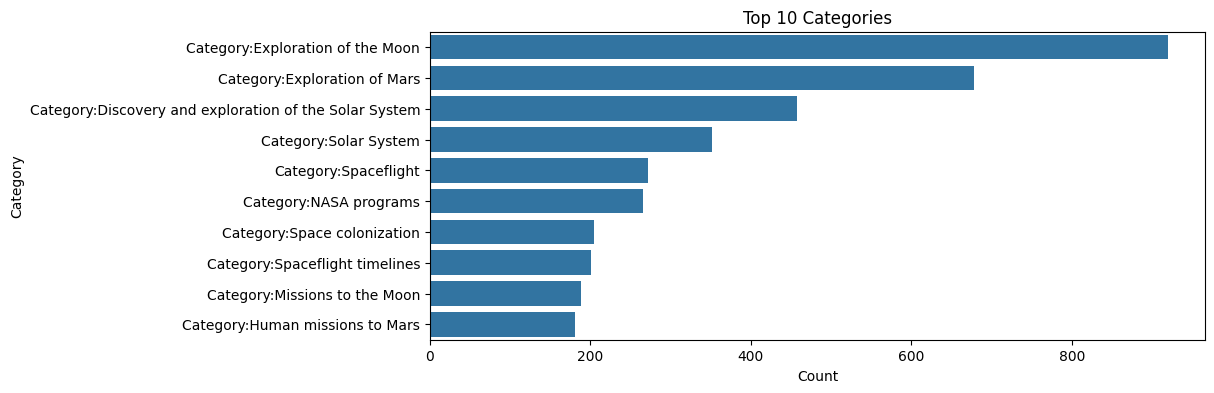

In [9]:
filtered_top_cats = [
    (cat, count) for cat, count in cat_counts.most_common()
    if not (cat.startswith("Category:Articles") or 
            cat.startswith("Category:CS1") or 
            cat.startswith("Category:Wikipedia") or 
            cat.startswith("Category:Pages") or 
            cat.startswith("Category:Vague") or 
            cat.startswith("Category:Use") or
            cat.startswith("Category:Short") or
            cat.startswith("Category:Webarchive") or
            cat.startswith("Category:All") or
            cat.startswith("Category:Commons"))][:10]

cats, counts = zip(*filtered_top_cats)
plt.figure(figsize=(10,4))
sns.barplot(x=list(counts), y=list(cats))
plt.title("Top 10 Categories")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

### Chunks per Article

count    141.000000
mean      15.007092
std       13.138546
min        2.000000
25%        7.000000
50%       10.000000
75%       20.000000
max       68.000000
Name: chunk_index, dtype: float64


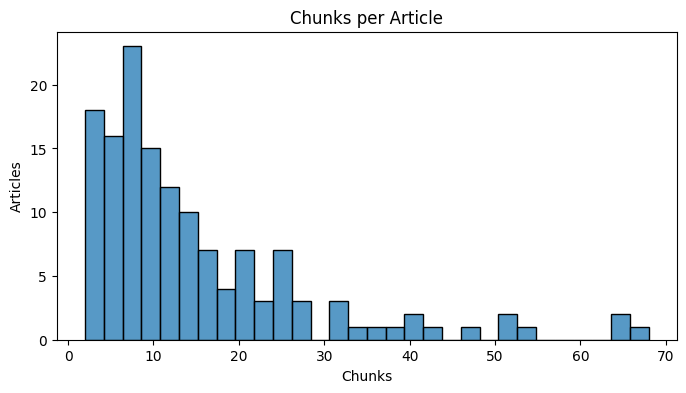

In [10]:
chunks_per_article = df.groupby('title')['chunk_index'].count()
print(chunks_per_article.describe())
plt.figure(figsize=(8,4))
sns.histplot(chunks_per_article, bins=30)
plt.title("Chunks per Article")
plt.xlabel("Chunks")
plt.ylabel("Articles")
plt.show()

### Chunks per Source

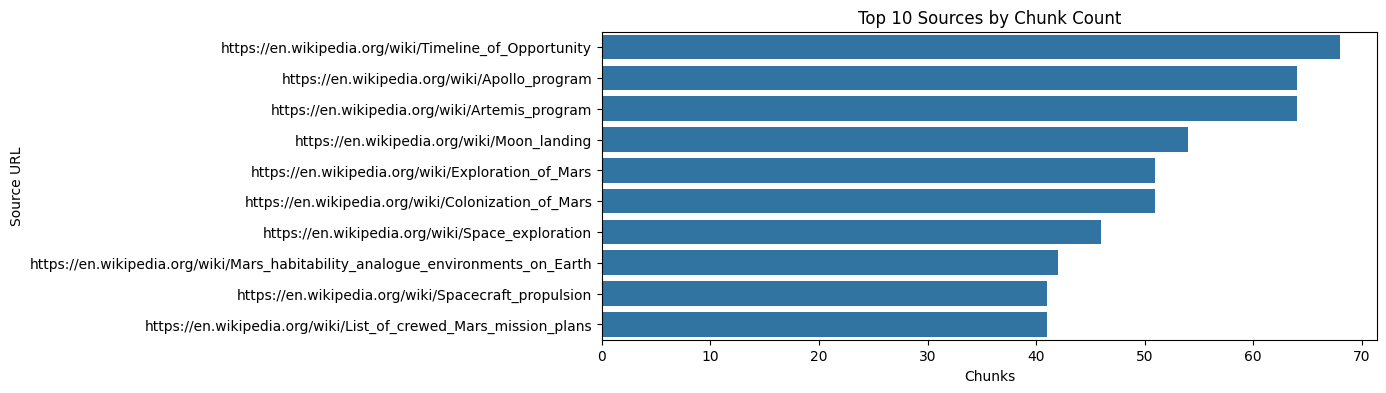

In [11]:
top_sources = df['source_url'].value_counts().head(10)
plt.figure(figsize=(10,4))
sns.barplot(x=top_sources.values, y=top_sources.index)
plt.title("Top 10 Sources by Chunk Count")
plt.xlabel("Chunks")
plt.ylabel("Source URL")
plt.show()

### Chunk Position Analysis

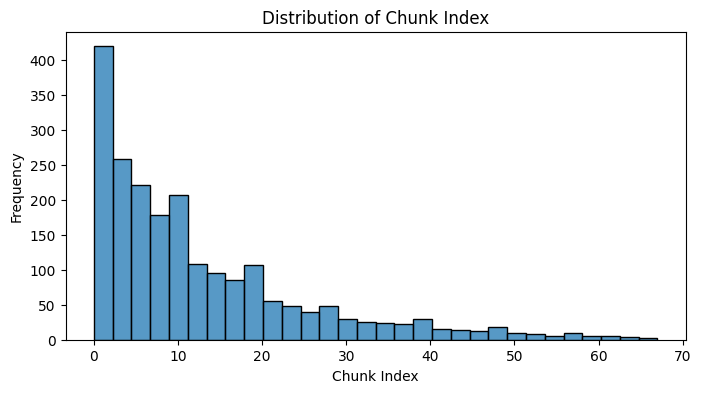

In [12]:
plt.figure(figsize=(8,4))
sns.histplot(df['chunk_index'], bins=30)
plt.title("Distribution of Chunk Index")
plt.xlabel("Chunk Index")
plt.ylabel("Frequency")
plt.show()

### Image Coverage

In [13]:
has_image = df['images'].apply(lambda x: bool(x) and x != '[]')
num_with_images = has_image.sum()
total_chunks = len(df)
percent_with_images = (num_with_images / total_chunks) * 100
print(f"Chunks with images: {num_with_images} / {total_chunks} ({percent_with_images:.2f}%)")

Chunks with images: 1997 / 2116 (94.38%)


### Chunks with and without Images by Category

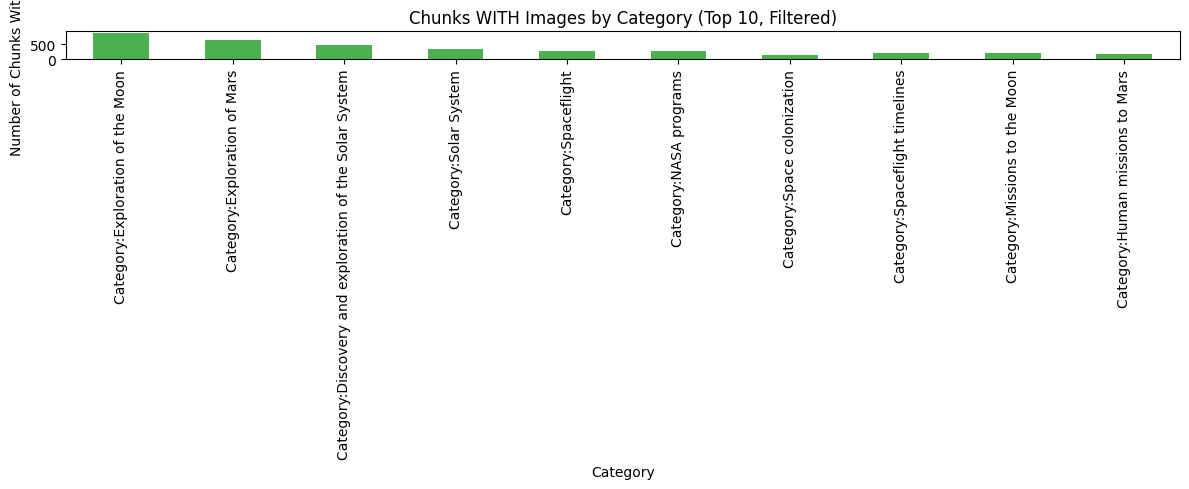

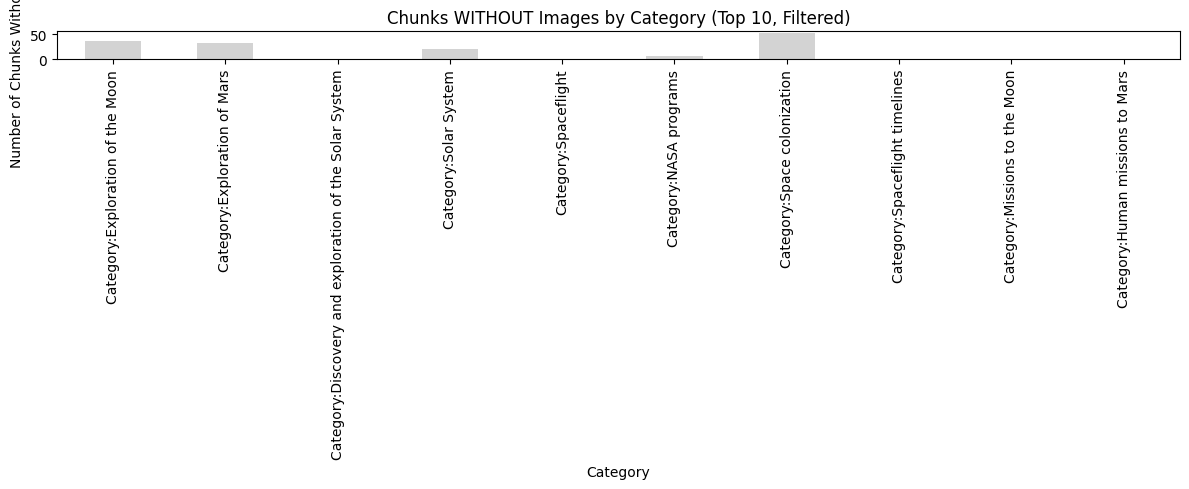

In [14]:
# Ensure categories are lists
if df['categories'].dtype == object and isinstance(df['categories'].iloc[0], str):
    df['categories'] = df['categories'].apply(lambda x: ast.literal_eval(x) if x.startswith('[') else [x])

# Create a flag for image presence
df['has_image'] = df['images'].apply(lambda x: bool(x) and x != '[]')

# Explode categories for per-category analysis
df_exploded = df.explode('categories')

# Filter out unwanted categories
def is_valid_category(cat):
    return not (
        cat.startswith("Category:Articles") or 
        cat.startswith("Category:CS1") or 
        cat.startswith("Category:Wikipedia") or 
        cat.startswith("Category:Pages") or 
        cat.startswith("Category:Vague") or 
        cat.startswith("Category:Use") or
        cat.startswith("Category:Short") or
        cat.startswith("Category:Webarchive") or
        cat.startswith("Category:All") or
        cat.startswith("Category:Commons")
    )

df_exploded_filtered = df_exploded[df_exploded['categories'].apply(is_valid_category)]

# Group by category and image flag
cat_img = df_exploded_filtered.groupby(['categories', 'has_image']).size().unstack(fill_value=0)

# Get top 10 categories by total count
top_cats = cat_img.sum(axis=1).sort_values(ascending=False).head(10).index
cat_img_top = cat_img.loc[top_cats]

# Plot chunks WITH images (True)
cat_img_top[True].plot(kind='bar', figsize=(12,5), color='#4caf50')
plt.title("Chunks WITH Images by Category (Top 10, Filtered)")
plt.xlabel("Category")
plt.ylabel("Number of Chunks With Images")
plt.tight_layout()
plt.show()

# Plot chunks WITHOUT images (False)
cat_img_top[False].plot(kind='bar', figsize=(12,5), color='#d3d3d3')
plt.title("Chunks WITHOUT Images by Category (Top 10, Filtered)")
plt.xlabel("Category")
plt.ylabel("Number of Chunks Without Images")
plt.tight_layout()
plt.show()

### Summary Length

In [15]:
df['summary_length'] = df['summary'].apply(lambda x: len(str(x).split()))
print(df['summary_length'].describe())

count    2116.000000
mean      201.075614
std       127.983816
min        19.000000
25%        99.000000
50%       184.000000
75%       271.000000
max       604.000000
Name: summary_length, dtype: float64


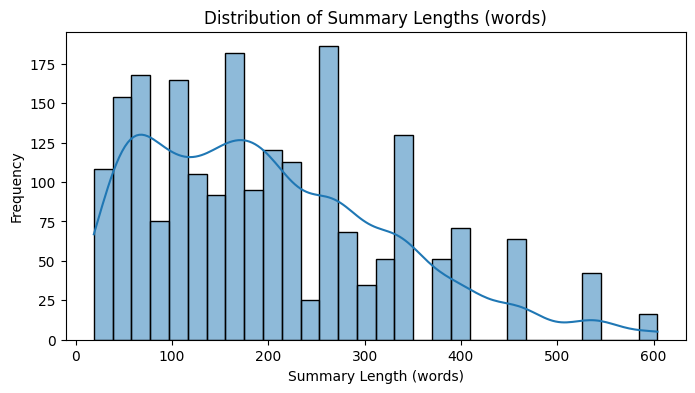

In [16]:
plt.figure(figsize=(8,4))
sns.histplot(df['summary_length'], bins=30, kde=True)
plt.title("Distribution of Summary Lengths (words)")
plt.xlabel("Summary Length (words)")
plt.ylabel("Frequency")
plt.show()

In [17]:
percent_with_summary = (df['summary'].apply(lambda x: bool(str(x).strip())).sum() / len(df)) * 100
print(f"Chunks with non-empty summary: {percent_with_summary:.2f}%")

Chunks with non-empty summary: 100.00%


### Text Length vs. Summary Length

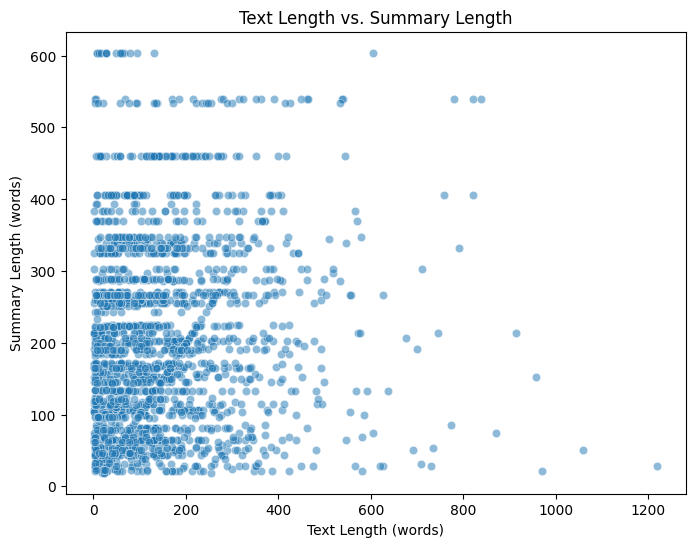

In [18]:
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
df['summary_length'] = df['summary'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,6))
sns.scatterplot(x='text_length', y='summary_length', data=df, alpha=0.5)
plt.title("Text Length vs. Summary Length")
plt.xlabel("Text Length (words)")
plt.ylabel("Summary Length (words)")
plt.show()

### Word Count Analysis

count    2116.000000
mean      143.108696
std       139.167326
min         1.000000
25%        44.000000
50%       105.000000
75%       195.000000
max      1220.000000
Name: word_count, dtype: float64


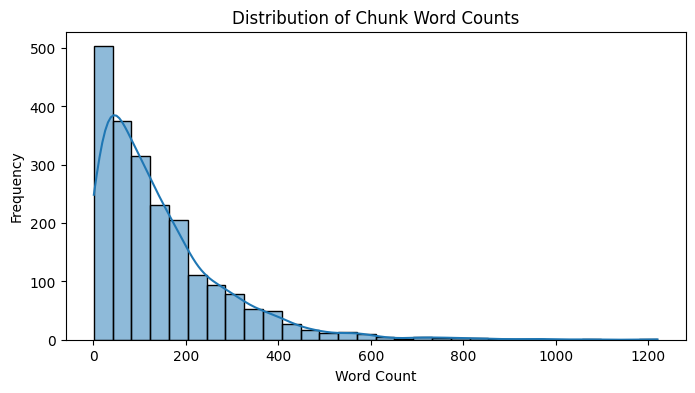

In [19]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
print(df['word_count'].describe())

plt.figure(figsize=(8,4))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.title("Distribution of Chunk Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

### Topic/Keyword Distribution (Word Cloud)

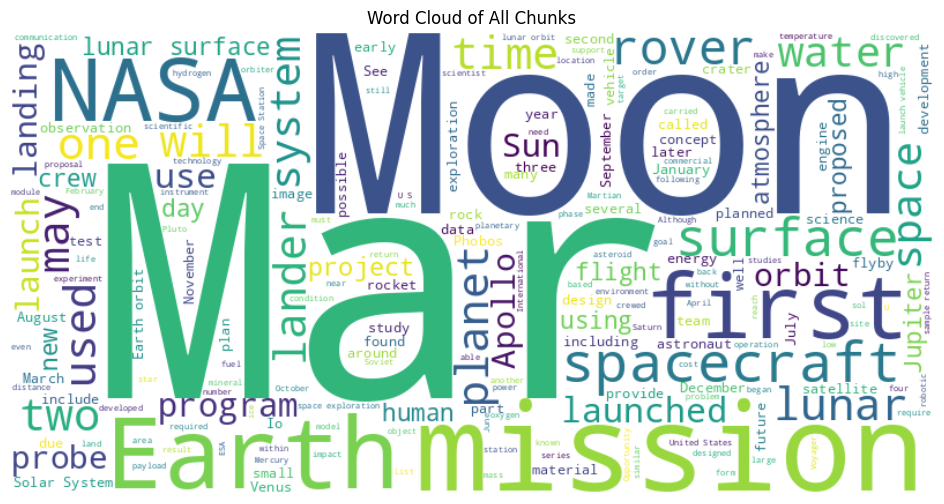

In [20]:
all_text = " ".join(df['text'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Chunks")
plt.show()

### Names Entity Frequency

In [21]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 43.1 MB/s  0:00:00m0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [22]:
nlp = spacy.load("en_core_web_sm")
entities = Counter()
for doc in nlp.pipe(df['text'].sample(min(100, len(df))), batch_size=20):
    entities.update([ent.label_ for ent in doc.ents])
print("Named entity counts (sample):", entities)

Named entity counts (sample): Counter({'ORG': 373, 'DATE': 298, 'PERSON': 261, 'LOC': 217, 'CARDINAL': 172, 'GPE': 109, 'QUANTITY': 81, 'PRODUCT': 64, 'ORDINAL': 64, 'NORP': 55, 'FAC': 25, 'WORK_OF_ART': 20, 'TIME': 12, 'MONEY': 10, 'PERCENT': 8, 'LAW': 3, 'EVENT': 1, 'LANGUAGE': 1})


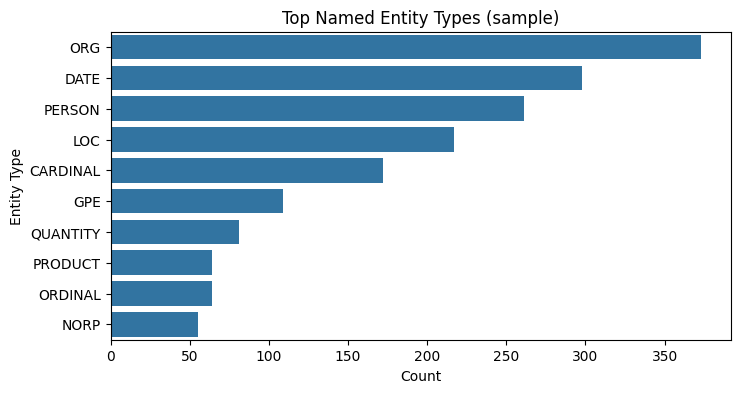

In [23]:
entity_labels, entity_counts = zip(*entities.most_common(10))
plt.figure(figsize=(8,4))
sns.barplot(x=list(entity_counts), y=list(entity_labels))
plt.title("Top Named Entity Types (sample)")
plt.xlabel("Count")
plt.ylabel("Entity Type")
plt.show()

### Correlation Analysis between Numeric Features

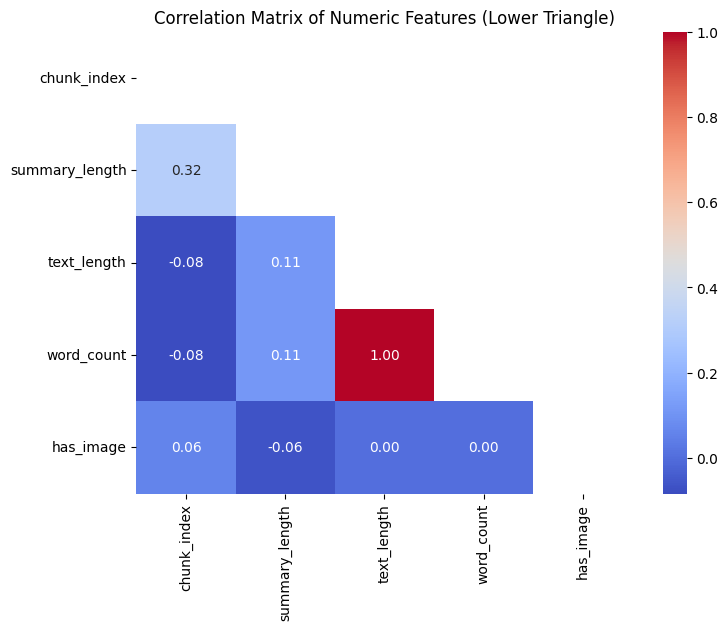

In [24]:
numeric_cols = [
    "chunk_index",
    "summary_length",
    "text_length",
    "word_count",
    "has_image"
]

# Ensure 'has_image' is numeric (0/1)
if "has_image" in df.columns and df["has_image"].dtype != int:
    df["has_image"] = df["has_image"].astype(int)

# Compute correlation matrix
corr = df[numeric_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(8,6))
sns.heatmap(corr, mask=mask, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numeric Features (Lower Triangle)")
plt.show()

### Observations

- 408 chunks
- 141 unique article titles and unique source URLs
- No missing or duplicate chunks
- Created_at are essentially all the same, but put in there in case we decide to add more data later
- Most articles have 1 or 2 chunks; the maximum number of chunks in an article is 12 - these are for articles on the Apollo program, the Artemis program, and the timeline of the Opportunity Rover
- 94.12% of the chunks have images associated with them
- Typical summary length is about 200 words
- Both average and maximum chunk length is 1000 (but we set that)
- Most popular topics were Moon, Mars, Earth, mission
- Most features are independent, except for text_length and word_count
- Summary length is somewhat related to chunk position and text length, but not strongly
- Image presence is almost independent of other features